# Network Intrusion Detection
## Talib Khweled

This program is intended to predict whether a TCP connection is a network intrusion or a regular connection, comparing results from both a standard fully connected neural network, or a Convolutional Neural Network

The dataset used is the 10% truncated dataset from KDD Cup 1999 Dataset which can be found at: 
http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html

In [124]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import Image

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, precision_score, roc_curve, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adadelta,Adam,RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


import wandb
from wandb.keras import WandbCallback

%matplotlib inline

In [16]:
def custom_encoder(outcome):
    if outcome in ['normal.']:
        return 0
    else:
        return 1

In [17]:
columns = ['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment',
            'urgent','hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted',
            'num_root','num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_host_login',
            'is_guest_login','count','srv_count','serror_rate','srv_serror_rate','rerror_rate',
            'srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count',
            'dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate',
            'dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate',
            'dst_host_rerror_rate','dst_host_srv_rerror_rate','outcome']

### Data Import and Initial Label Encoding
Here we are reading in our dataset, and dropping all redundant rows. We are also applying an encoder to generalize our labels into 2 classes, (1) for a threat, and (0) for a normal connection.

In [18]:
# Read in dataset
df = pd.read_csv('data/network_intrusion_data.csv', names=columns)

# Categorize outcomes into binary values
df['outcome'] = df['outcome'].apply(custom_encoder)

# remove redundant rows
df = df.drop_duplicates()

### Data Inspection and Visualization
Here we can take our first look at the dataset, and its columns.

In [19]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,0
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,0
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0


In [20]:
# Display general information, we are looking for null values
print(df.info())
print("\nNumber of NaN values:", df.isnull().sum().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145585 entries, 0 to 494020
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     145585 non-null  int64  
 1   protocol_type                145585 non-null  object 
 2   service                      145585 non-null  object 
 3   flag                         145585 non-null  object 
 4   src_bytes                    145585 non-null  int64  
 5   dst_bytes                    145585 non-null  int64  
 6   land                         145585 non-null  int64  
 7   wrong_fragment               145585 non-null  int64  
 8   urgent                       145585 non-null  int64  
 9   hot                          145585 non-null  int64  
 10  num_failed_logins            145585 non-null  int64  
 11  logged_in                    145585 non-null  int64  
 12  num_compromised              145585 non-null  int64  
 13 

**Here, we can use a heatmap to look at correlations, to see which features matter the most.**

<AxesSubplot:>

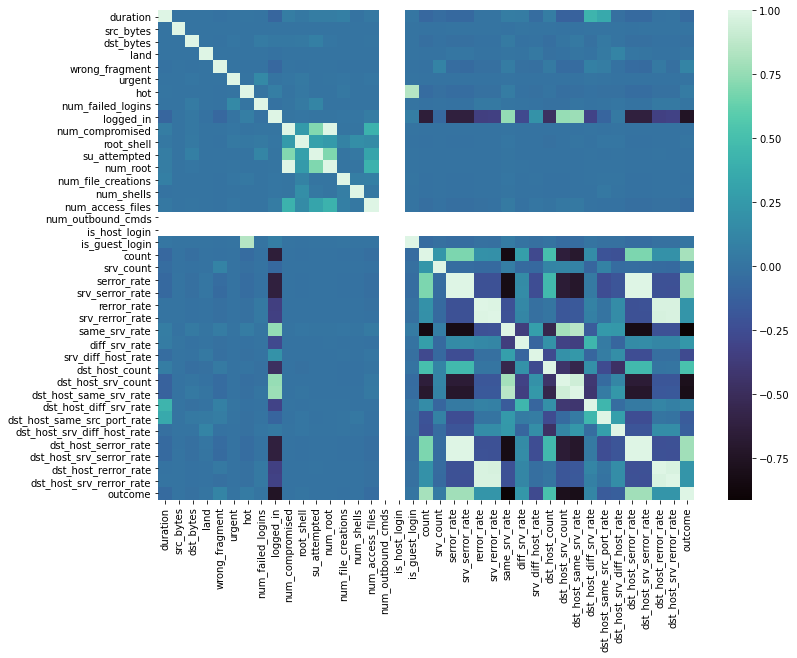

In [21]:
correlations = df.corr()

plt.figure(figsize=(12,9))

sns.heatmap(correlations,cmap=sns.color_palette("mako", as_cmap=True))

**We see a strange pattern in the columns for *'is_host_login'* and *'num_outbound_cmds'*, after further inspection, we can see below that the values are all 0s. With a columnn of constant values, these features have no use to us, and will be dropped.**

In [22]:
# We can see the range of values here
df[['is_host_login','num_outbound_cmds']].describe()

,is_host_login,num_outbound_cmds
count,145585.0,145585.0
mean,0.0,0.0
std,0.0,0.0
min,0.0,0.0
25%,0.0,0.0
50%,0.0,0.0
75%,0.0,0.0
max,0.0,0.0


In [23]:
# drop the columns
df = df.drop(columns=['is_host_login','num_outbound_cmds'])

<AxesSubplot:>

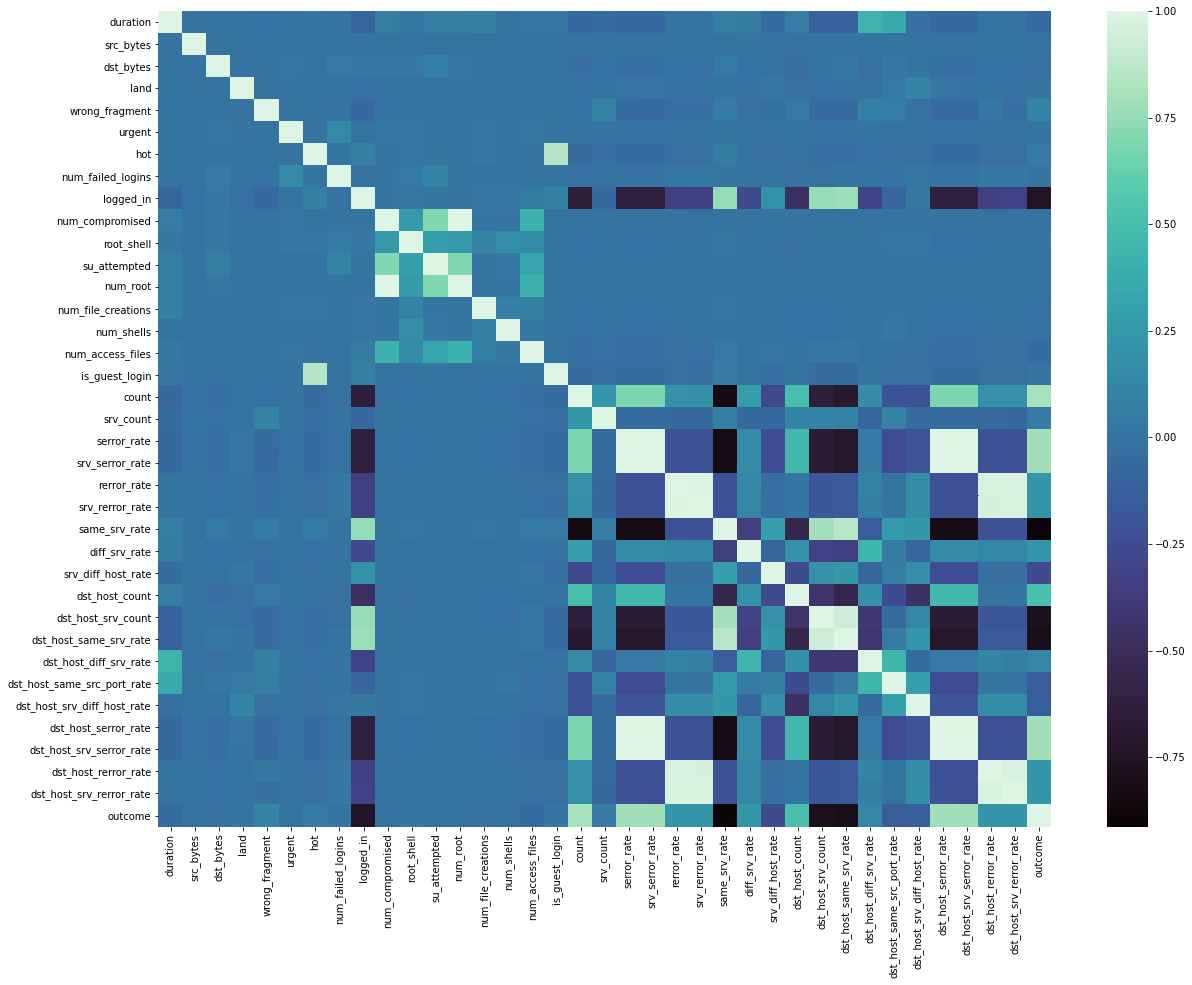

In [24]:
# look back at new heat map
correlations = df.corr()

plt.figure(figsize=(20,15))

sns.heatmap(correlations,cmap=sns.color_palette("mako", as_cmap=True))

Here we can see we have 4 parameters that have a strong negative correlation to our target, and 5 have a strong positive correlation. In building a future model, we can perhaps structure it to focus on these variables.

### Data Scaling and Encoding

In [25]:
numeric_cols = [i for i in df.columns if i not in ['protocol_type','service', 'flag', 'land', 'logged_in',
                                                   'is_guest_login', 'outcome']]
categorical_cols_to_encode = ['protocol_type','service', 'flag']
# define our scaler
mms = MinMaxScaler()
# Scale numeric categories
df[numeric_cols] = mms.fit_transform(df[numeric_cols])
# Encode categorical categories
df = pd.get_dummies(df, columns=categorical_cols_to_encode)

In [26]:
# Small function to check for any null values after scaling
df.isnull().any().sum()

0

In [27]:
X_cols = [i for i in df.columns if i is not 'outcome']

X_train, X_test, y_train, y_test = train_test_split(df[X_cols], df['outcome'], test_size=0.2, random_state=42)

In [29]:
X_train.shape

(116468, 116)

## Model Construction and Training

In [119]:
run = wandb.init(project='Project2',
           config={
            "hyper": "parameter"
            })

wandb: wandb version 0.10.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [30]:
batch_size = 32
epochs = 100

### Dense Neural Network Construction

In [54]:
# Model construction

model = Sequential()

model.add(Dense(116, input_shape=(116,)))
model.add(Activation('relu'))

model.add(Dense(87, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(10, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='SGD')

print (model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 116)               13572     
_________________________________________________________________
activation (Activation)      (None, 116)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 87)                10179     
_________________________________________________________________
dropout_18 (Dropout)         (None, 87)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 10)                880       
_________________________________________________________________
dropout_19 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 1)                

In [50]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=20, verbose=2, mode='auto')

checkpointer = ModelCheckpoint(filepath="data/Dense/Dense-SGD.hdf5", verbose=1, save_best_only=True)

model.fit(X_train, y_train, batch_size=batch_size,
          validation_data=(X_test, y_test),
          callbacks=[WandbCallback(), monitor, checkpointer],
          epochs=epochs, verbose=2)

# Re-load best weights to evaluate
model.load_weights('data/Dense/Dense-SGD.hdf5')

# This is to stop the monitoring tool
run.finish()

Epoch 1/100

Epoch 00001: val_loss improved from inf to 0.05464, saving model to data/new_weights.hdf5
3640/3640 - 5s - loss: 0.1330 - val_loss: 0.0546
Epoch 2/100

Epoch 00002: val_loss improved from 0.05464 to 0.04435, saving model to data/new_weights.hdf5
3640/3640 - 5s - loss: 0.0714 - val_loss: 0.0444
Epoch 3/100

Epoch 00003: val_loss improved from 0.04435 to 0.03688, saving model to data/new_weights.hdf5
3640/3640 - 5s - loss: 0.0584 - val_loss: 0.0369
Epoch 4/100

Epoch 00004: val_loss improved from 0.03688 to 0.03147, saving model to data/new_weights.hdf5
3640/3640 - 5s - loss: 0.0496 - val_loss: 0.0315
Epoch 5/100

Epoch 00005: val_loss improved from 0.03147 to 0.02797, saving model to data/new_weights.hdf5
3640/3640 - 5s - loss: 0.0440 - val_loss: 0.0280
Epoch 6/100

Epoch 00006: val_loss improved from 0.02797 to 0.02542, saving model to data/new_weights.hdf5
3640/3640 - 5s - loss: 0.0395 - val_loss: 0.0254
Epoch 7/100

Epoch 00007: val_loss improved from 0.02542 to 0.02323,

Epoch 61/100

Epoch 00061: val_loss improved from 0.00495 to 0.00479, saving model to data/new_weights.hdf5
3640/3640 - 5s - loss: 0.0078 - val_loss: 0.0048
Epoch 62/100

Epoch 00062: val_loss did not improve from 0.00479
3640/3640 - 4s - loss: 0.0083 - val_loss: 0.0048
Epoch 63/100

Epoch 00063: val_loss did not improve from 0.00479
3640/3640 - 5s - loss: 0.0077 - val_loss: 0.0048
Epoch 64/100

Epoch 00064: val_loss did not improve from 0.00479
3640/3640 - 5s - loss: 0.0083 - val_loss: 0.0053
Epoch 65/100

Epoch 00065: val_loss did not improve from 0.00479
3640/3640 - 5s - loss: 0.0075 - val_loss: 0.0052
Epoch 66/100

Epoch 00066: val_loss did not improve from 0.00479
3640/3640 - 5s - loss: 0.0072 - val_loss: 0.0049
Epoch 67/100

Epoch 00067: val_loss did not improve from 0.00479
3640/3640 - 5s - loss: 0.0075 - val_loss: 0.0050
Epoch 68/100

Epoch 00068: val_loss did not improve from 0.00479
3640/3640 - 5s - loss: 0.0079 - val_loss: 0.0048
Epoch 69/100

Epoch 00069: val_loss improved 

epoch,88
loss,0.00744
val_loss,0.00599
_step,88
_runtime,432
_timestamp,1602836328
best_val_loss,0.00462
best_epoch,75


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▄▃▂▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


In [90]:
model.load_weights('data/Dense/Dense-SGD.hdf5')

# predict test values, round into proper class
validation_preds = model.predict(X_test)
validation_preds = np.round(validation_preds)

# calculate metrics
precision = precision_score(y_test, validation_preds, average='weighted')
recall = recall_score(y_test, validation_preds, average='weighted')
score = f1_score(y_test, validation_preds, average='weighted')

print("Precision score: {}".format(precision))
print("Recall score: {}".format(recall))
print("F1 score: {}".format(score))

Precision score: 0.9987980529049559
Recall score: 0.9987979530858262
F1 score: 0.9987978539373346


<AxesSubplot:>

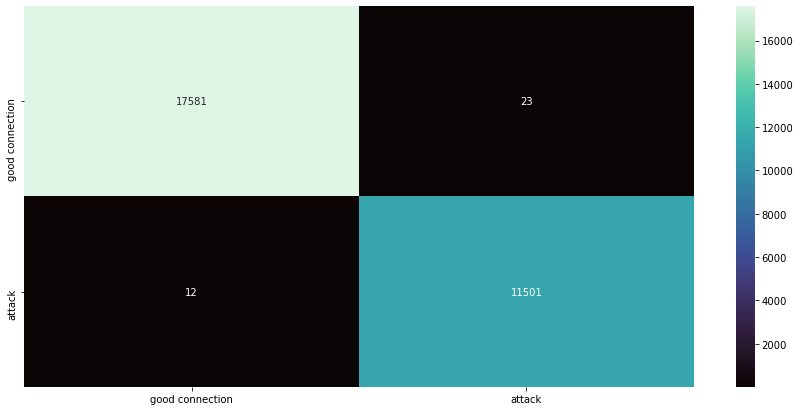

In [93]:
cfm = confusion_matrix(validation_preds, y_test)
plt.figure(figsize=(15,7))
sns.heatmap(cfm,cmap=sns.color_palette("mako", as_cmap=True), annot=True,fmt='',
            xticklabels=['good connection', 'attack'], yticklabels=['good connection', 'attack'])

### Prepare data for CNN
The data does not fit into the model properly in the previous format, so we do some reshaping, and change our lables to 2 columns

In [35]:
y_train_cnn = tf.keras.utils.to_categorical(y_train, 2)
y_test_cnn = tf.keras.utils.to_categorical(y_test, 2)

X_train_cnn = X_train.to_numpy().reshape((X_train.shape[0],1,X_train.shape[1],1))
X_test_cnn = X_test.to_numpy().reshape((X_test.shape[0],1,X_test.shape[1],1))

### Convolutional Neural Network Construction

In [116]:
cnn_model = Sequential()

cnn_model.add(Conv2D(64, kernel_size=(1,4), strides=(1,1), activation='relu', input_shape=(1, 116, 1)))

cnn_model.add(MaxPooling2D(pool_size=(1,2)))

cnn_model.add(Flatten())

cnn_model.add(Dense(1000, activation='relu'))

cnn_model.add(Dense(750, activation='relu'))

cnn_model.add(Dropout(0.5))

cnn_model.add(Dense(500, activation='relu'))

cnn_model.add(Dense(100, activation='relu'))

cnn_model.add(Dropout(0.2))

cnn_model.add(Dense(10, activation='relu'))

cnn_model.add(Dropout(0.2))

cnn_model.add(Dense(2, activation='softmax'))

cnn_model.compile(loss='categorical_crossentropy', optimizer='SGD')

print (cnn_model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 1, 113, 64)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 1, 56, 64)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 3584)              0         
_________________________________________________________________
dense_40 (Dense)             (None, 1000)              3585000   
_________________________________________________________________
dense_41 (Dense)             (None, 750)               750750    
_________________________________________________________________
dropout_20 (Dropout)         (None, 750)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 500)              

In [33]:
X_test.shape

(29117, 116)

In [121]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=20, verbose=2, mode='auto')

checkpointer = ModelCheckpoint(filepath="data/CNN/new_run.hdf5", verbose=2, save_best_only=True)

cnn_model.fit(X_train_cnn, y_train_cnn,
          validation_data=(X_test_cnn, y_test_cnn),
          callbacks=[WandbCallback(), monitor, checkpointer],
          epochs=epochs, verbose=2)

# Re-load best weights to evaluate
cnn_model.load_weights('data/CNN/new_run.hdf5')

# This is to stop the monitoring tool
run.finish()

Epoch 1/100

Epoch 00001: val_loss improved from inf to 0.00712, saving model to data/CNN/new_run.hdf5
3640/3640 - 9s - loss: 0.0063 - val_loss: 0.0071
Epoch 2/100

Epoch 00002: val_loss improved from 0.00712 to 0.00476, saving model to data/CNN/new_run.hdf5
3640/3640 - 10s - loss: 0.0068 - val_loss: 0.0048
Epoch 3/100

Epoch 00003: val_loss improved from 0.00476 to 0.00462, saving model to data/CNN/new_run.hdf5
3640/3640 - 9s - loss: 0.0061 - val_loss: 0.0046
Epoch 4/100

Epoch 00004: val_loss did not improve from 0.00462
3640/3640 - 8s - loss: 0.0062 - val_loss: 0.0054
Epoch 5/100

Epoch 00005: val_loss did not improve from 0.00462
3640/3640 - 9s - loss: 0.0063 - val_loss: 0.0053
Epoch 6/100

Epoch 00006: val_loss did not improve from 0.00462
3640/3640 - 8s - loss: 0.0065 - val_loss: 0.0051
Epoch 7/100

Epoch 00007: val_loss improved from 0.00462 to 0.00450, saving model to data/CNN/new_run.hdf5
3640/3640 - 8s - loss: 0.0058 - val_loss: 0.0045
Epoch 8/100

Epoch 00008: val_loss did n

epoch,46
loss,0.00439
val_loss,0.00525
_step,46
_runtime,407
_timestamp,1602874861
best_val_loss,0.00429
best_epoch,26


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,▇█▆▆▇▇▅▅▆▆▅▆▄▅▄▆▅▄▅▃▄▄▃▄▃▄▄▃▃▄▃▃▃▂▃▃▃▁▃▂
val_loss,▅▁▁▂▂▂▂▄▂▂▁▁█▂▃▂▁▂▃▂▂▁▁▄▂▃▁▁▃▁▁▂▄▂▃▂▂▂▂▂
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


### Evaluation

In [122]:
cnn_model.load_weights('data/CNN/final_run.hdf5')

# predict test values, round into proper class
validation_preds = cnn_model.predict(X_test_cnn)
validation_preds = np.round(validation_preds)

# calculate metrics
precision = precision_score(y_test_cnn, validation_preds, average='weighted')
recall = recall_score(y_test_cnn, validation_preds, average='weighted')
score = f1_score(y_test_cnn, validation_preds, average='weighted')

print("Precision score: {}".format(precision))
print("Recall score: {}".format(recall))
print("F1 score: {}".format(score))


Precision score: 0.9986949693963547
Recall score: 0.9986949204931826
F1 score: 0.9986949400197014


<AxesSubplot:>

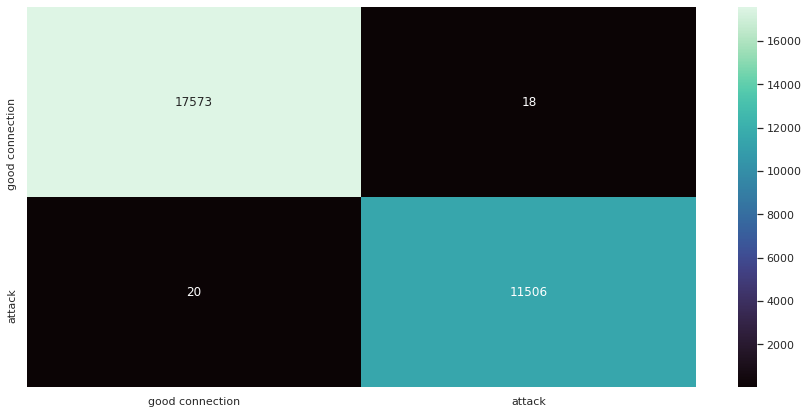

In [123]:
cfm = confusion_matrix(validation_preds.argmax(axis=1), y_test_cnn.argmax(axis=1))
plt.figure(figsize=(15,7))
sns.heatmap(cfm,cmap=sns.color_palette("mako", as_cmap=True), annot=True,fmt='',
            xticklabels=['good connection', 'attack'], yticklabels=['good connection', 'attack'])

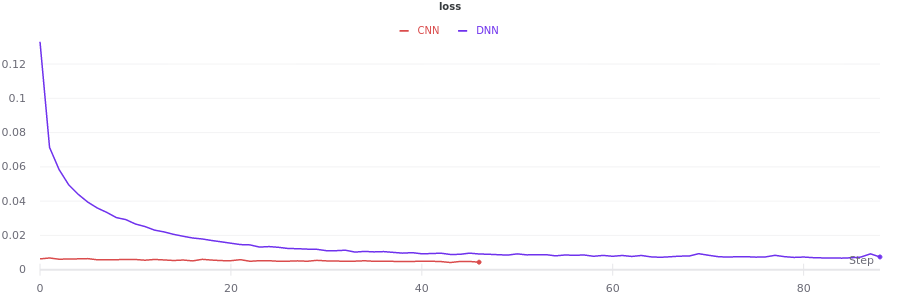

In [126]:
Image('loss.png')

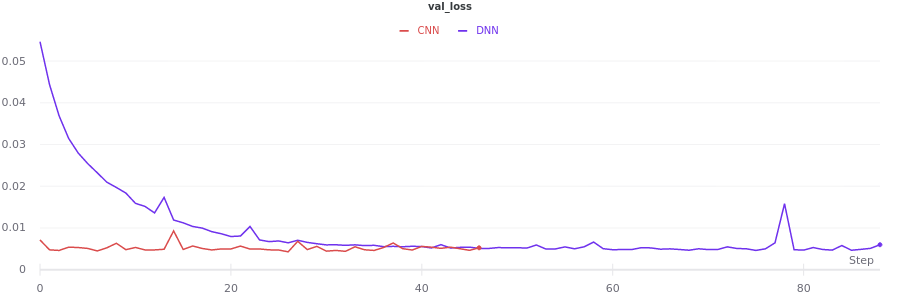

In [127]:
Image('val_loss.png')